# Minimal script to train a variational auto-encoder on the MNIST dataset

In [1]:
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
from theano import config

from collections import OrderedDict
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import functions

import sys
import time
import numpy as np
import scipy
import pickle
import os.path

%matplotlib inline

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


Download the MNIST dataset and get the images

In [2]:
train_set_x,valid_set_x = functions.load_dataset()

(-0.5, 27.5, 27.5, -0.5)

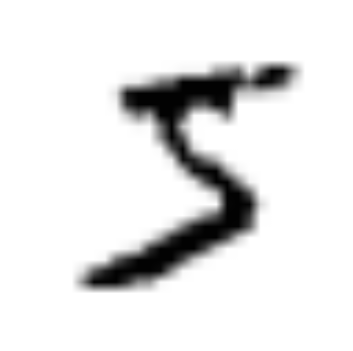

In [3]:
plt.imshow(train_set_x[0,0])
plt.set_cmap('Greys')
plt.axis('off')

Turn the 2D images into Vectors


In [5]:
train_set_x = train_set_x.reshape([train_set_x.shape[0],784])
valid_set_x = valid_set_x.reshape([valid_set_x.shape[0],784])
print(train_set_x.shape)
print(valid_set_x.shape)

(60000, 784)
(10000, 784)


Define the parameters of your VAE

In [25]:
HU_enc = 500  # Size of the hidden Layers for the decoding/encoding network
HU_dec = 500
dimZ   = 2    # Dimensionality of your latent space (chose 2 if you want to visualize the result)
b_size = 100  # Batch Size
epochs = 1300 # Training epochs (number of iterations thorugh the whole dataset)

N = train_set_x.shape[0]     # Number of images

Initialize the parameters

In [27]:
def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)
    
def init_weights(shape, scale = 0.01, name = None):
    """ Initialize random gaussian weights """
    return theano.shared(floatX(np.random.randn(*shape) * scale), name = name)
    
def init_biases(shape, scale = 0.01, name = None):
    """ Initialize random gaussian biases. Broadcasting allows to concatentate the bias to match the batchsize """
    return theano.shared(floatX(np.random.randn(shape,1)* scale), name = name, broadcastable=(False, True))

X = T.fmatrix() #T Theanotensors for the data and latent variables
Z = T.fmatrix()

W1 = init_weights((HU_enc, 28*28), name = 'W1') # 28*28 is the image size
b1 = init_biases((HU_enc), name = 'b1')

W2 = init_weights((dimZ, HU_enc), name = 'W2')
b2 = init_biases((dimZ), name = 'b2')

W3 = init_weights((dimZ, HU_enc), name = 'W3')
b3 = init_biases((dimZ), name = 'b3')

W4 = init_weights((HU_dec, dimZ), name = 'W4')
b4 = init_biases((HU_dec), name = 'b4')

W5 = init_weights((28*28, HU_dec), name = 'W5')
b5 = init_biases((28*28), name = 'b5')

The actual model

In [19]:
def model(x, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5, batch_size):

    eps = theano.shared(floatX(np.random.randn(dimZ, batch_size))) # Epsilon is drawn from a gaussian to sample from z
                                                                   # for the reparametrization trick
        
    h_enc =         T.tanh(T.dot(W1,x) + b1)                       # encoding part
    mu_enc =        T.dot(W2,h_enc) + b2
    log_sig_enc =   0.5*(T.dot(W3,h_enc) + b3)
    
    z =             mu_enc + T.exp(log_sig_enc)*eps                # latent var.
    
    prior = 0.5 *   T.sum(1 + 2*log_sig_enc - mu_enc**2 - T.exp(3*log_sig_enc)) # regularizing term of the lower bound 
    
    h_dec =         T.tanh(T.dot(W4,z) + b4)                      # decoding part for binary variables
    y =             T.nnet.sigmoid(T.dot(W5,h_dec) + b5)          # y is the probability
    logpxz =        T.sum(x*T.log(y) + (1 - x)*T.log(1 - y))      # reconstruction term   
    
    bound = (prior + logpxz)/batch_size                           # lower bound
    
    return bound

cost = model(X, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5, b_size)   # The cost that gets minimized is just the lower bound
params = [W1, W2, W3, W4, W5, b1, b2, b3, b4, b5]

The update function

In [20]:
def adagrad_w_prior(loss_or_grads, params, factor, learning_rate=1.0, epsilon=1e-6):
    """See lasagne.updates.adagrad for details. I copied the function and added a prior to regularize the weights"""
    grads = theano.grad(loss_or_grads, params)
    updates = OrderedDict()

    for param, grad in zip(params, grads):
        value = param.get_value(borrow=True)
        accu = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                             broadcastable=param.broadcastable)
        accu_new = accu + grad ** 2
        updates[accu] = accu_new
        
        if param.name.count('W') == 1: # Weights are regularized, but not biases.
            updates[param] = param - (learning_rate * (grad + 2*factor*param) / T.sqrt(accu_new + epsilon))
        else:
            updates[param] = param - (learning_rate * (grad / T.sqrt(accu_new + epsilon)))

    return updates

updates = adagrad_w_prior(-cost , params, b_size/N ,learning_rate = 0.01)

train = theano.function(inputs=[X], updates=updates, allow_input_downcast=True)  # Trains and updates the weights
valid = theano.function(inputs=[X], outputs= cost, allow_input_downcast=True)    # Returns the lower bound (for readout)

Perform training


In [ ]:
bound_train = np.empty(epochs)
bound_valid = np.empty(epochs)

for i in range(epochs):
    
    t0 = time.time()        
    
    bound_t = 0
    bound_v = 0
    
    #For every batch, update the parameters and calculate the bound for the training and validation set. 
    for start, end in zip(range(0, len(train_set_x), b_size), range(b_size, len(train_set_x), b_size)):
        train(train_set_x[start:end].T)
        
    for start, end in zip(range(0, len(train_set_x), b_size), range(b_size, len(train_set_x), b_size)):
        bound_t += valid(train_set_x[start:end].T)   
        
    for start, end in zip(range(0, len(valid_set_x), b_size), range(b_size, len(valid_set_x), b_size)):
        bound_v += valid(valid_set_x[start:end].T)          

    bound_train[i] = bound_t/(len(train_set_x)/b_size)    
    bound_valid[i] = bound_v/(len(valid_set_x)/b_size) 
    timing         = time.time()-t0          # Time per epoch
    
    if i%50 == 0:
        print(i, bound_valid[i], timing)


0 -186.989116669 3.2022933959960938
50 -163.463549957 3.1855995655059814
100 -159.965274658 3.24428129196167


Plot the lower bound


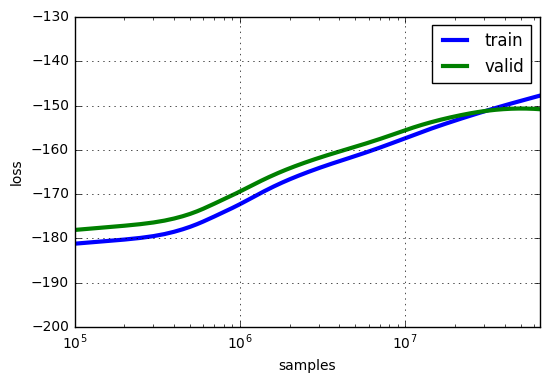

In [7]:
plt.plot(N*np.arange(len(bound_train)), bound_train, linewidth=3, label="train")
plt.plot(N*np.arange(len(bound_valid)), bound_valid, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("samples")
plt.ylabel("loss")
plt.xscale("log")
plt.xlim(1e5, N*len(bound_train))
plt.ylim(-200,-130)
plt.show()

Sample from your latent space

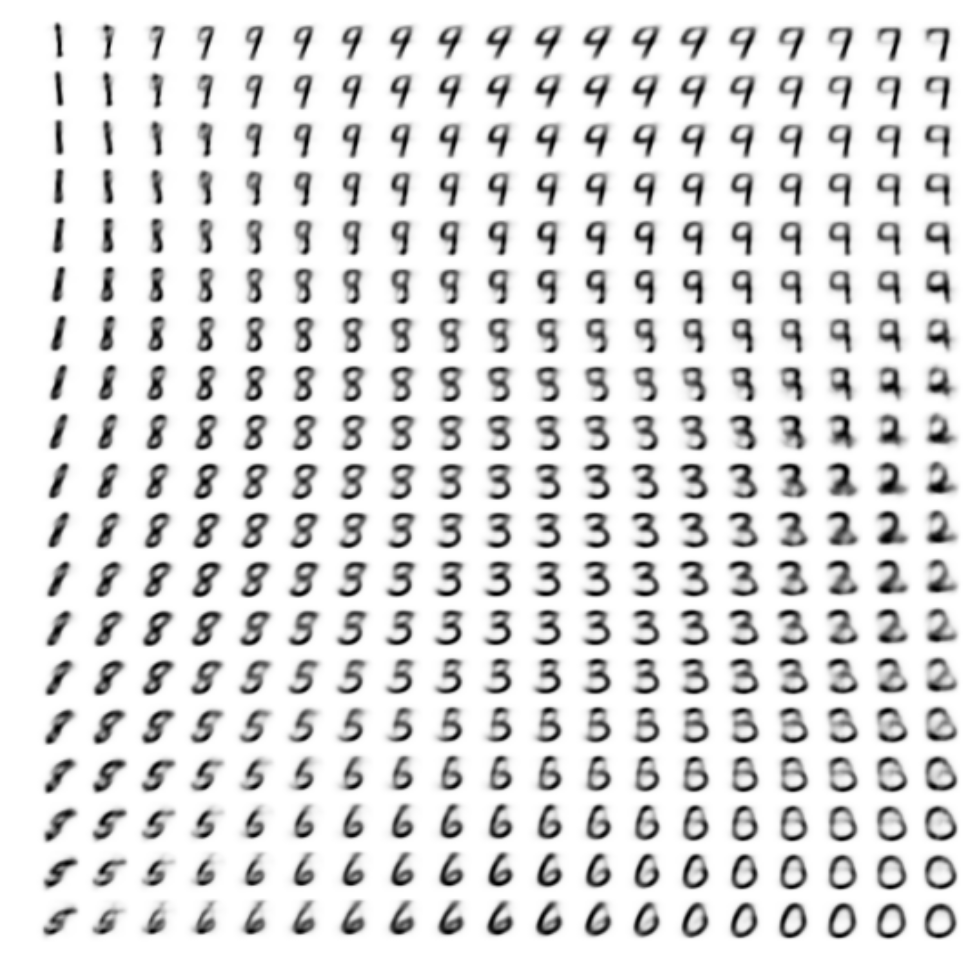

In [9]:
from scipy.stats import norm
def latent_rec(z, W4, W5, b4, b5):

    h_dec =         T.tanh(T.dot(W4,z) + b4)
    y =             T.nnet.sigmoid(T.dot(W5,h_dec) + b5)
    
    return y

reconstruction = latent_rec(Z, W4, W5, b4, b5)
get_sample = theano.function(inputs=[Z], outputs = reconstruction, allow_input_downcast=True)

plt.figure(frameon=False, figsize = (12,12))

gs1 = gridspec.GridSpec(19, 19)
gs1.update(wspace=0.0, hspace=0.0) # set the spacing between axes. 

count = 0

for i in np.arange(0.05,1.,0.05):
    for j in np.arange(0.05,1.,0.05):
        plt.subplot(gs1[count])
        z = np.array([scipy.stats.norm.ppf(i),scipy.stats.norm.ppf(j)])
        z=z.reshape(z.shape[0],1) 
        shared_z = theano.shared(np.asarray(z,dtype=theano.config.floatX),borrow=True)
        rec = np.reshape(get_sample(z),[28,28])
        plt.imshow(rec)
        plt.set_cmap('Greys')
        plt.axis('off')
        count += 1